In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


In [ ]:
datapath = '/content/drive/MyDrive/4.1/PRML Lab/RTA Dataset.csv'
df = pd.read_csv(datapath)

df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [ ]:
print(df.columns)

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')


In [ ]:
df = df.drop(columns=['Number_of_casualties', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality'])

In [ ]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved', 'Vehicle_movement',
       'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [ ]:
unique_counts = df.nunique()
print(unique_counts)

Time                           1074
Day_of_week                       7
Age_band_of_driver                5
Sex_of_driver                     3
Educational_level                 7
Vehicle_driver_relation           4
Driving_experience                7
Type_of_vehicle                  17
Owner_of_vehicle                  4
Service_year_of_vehicle           6
Defect_of_vehicle                 3
Area_accident_occured            14
Lanes_or_Medians                  7
Road_allignment                   9
Types_of_Junction                 8
Road_surface_type                 5
Road_surface_conditions           4
Light_conditions                  4
Weather_conditions                9
Type_of_collision                10
Number_of_vehicles_involved       6
Vehicle_movement                 13
Pedestrian_movement               9
Cause_of_accident                20
Accident_severity                 3
dtype: int64


In [ ]:
print(df.isnull().sum())

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Vehicle_movement                308
Pedestrian_movement               0
Cause_of_accident                 0
Accident_severity                 0
dtype: int64


In [ ]:
#save the dataset
df.to_csv('/content/drive/MyDrive/4.1/PRML Lab/Cleaned RTA Dataset.csv', index=False)

# NULL Handled

In [ ]:
def predictive_imputation(df):
    # Create a copy to avoid modifying the original DataFrame
    df_imputed = df.copy()

    # Identify columns with missing values
    cols_with_nan = df_imputed.columns[df_imputed.isnull().any()]

    for target in cols_with_nan:
        print(f"Imputing column: {target}")

        # Separate rows with observed vs. missing target values
        train_data = df_imputed[df_imputed[target].notnull()].copy()
        test_data  = df_imputed[df_imputed[target].isnull()].copy()

        # If there is nothing to predict or nothing to train on, skip
        if train_data.empty or test_data.empty:
            continue

        # Define predictor columns (all columns except the target)
        predictors = [col for col in df_imputed.columns if col != target]

        # Impute missing values in predictors using simple strategies:
        # Use median for numeric features and most frequent for categorical features.
        for col in predictors:
            if train_data[col].isnull().any():
                if train_data[col].dtype == 'object' or train_data[col].dtype.name == 'category':
                    imp = SimpleImputer(strategy='most_frequent')
                else:
                    imp = SimpleImputer(strategy='median')
                train_data[col] = imp.fit_transform(train_data[[col]]).ravel() # ravel to flatten array
                test_data[col] = imp.transform(test_data[[col]]).ravel() # ravel to flatten array


        # Determine whether the target is categorical or numeric
        is_categorical = (train_data[target].dtype == 'object' or
                          train_data[target].dtype.name == 'category')

        # Prepare predictors for model training: encode categorical features

        X_train = train_data[predictors].copy()
        X_test  = test_data[predictors].copy()
        for col in X_train.columns:
            if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
              if col == 'Time':
                X_train[col] = pd.to_datetime(X_train[col]).dt.hour
                X_test[col] = pd.to_datetime(X_test[col]).dt.hour
              else:

                le = LabelEncoder()
                # Fit on training data and transform both training and test sets
                X_train[col] = le.fit_transform(X_train[col].astype(str))
                try:
                  X_test[col] = le.transform(X_test[col].astype(str))
                except ValueError as e:
                  unseen_labels = set(X_test[col].astype(str)) - set(le.classes_)
                  for label in unseen_labels:
                    le.classes_ = np.append(le.classes_, label)
                  X_test[col] = le.transform(X_test[col].astype(str))




        # Predict missing values using a suitable model:
        if is_categorical:
            # Encode the target column
            le_target = LabelEncoder()
            y_train = le_target.fit_transform(train_data[target].astype(str))
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Reverse the label encoding for predictions
            predicted = le_target.inverse_transform(y_pred)
        else:
            y_train = train_data[target]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            predicted = model.predict(X_test)

        # Fill the missing values in the original DataFrame
        df_imputed.loc[df_imputed[target].isnull(), target] = predicted

    return df_imputed

# Example usage:
# df = pd.read_csv('your_dataset.csv')
df_imputed = predictive_imputation(df)
# Check that missing values have been filled:
print(df_imputed.isnull().sum())


Imputing column: Educational_level


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Vehicle_driver_relation


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Driving_experience


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Type_of_vehicle


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Owner_of_vehicle


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Service_year_of_vehicle


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Defect_of_vehicle


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Area_accident_occured


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Lanes_or_Medians


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Road_allignment


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Types_of_Junction


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Road_surface_type


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Type_of_collision


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Vehicle_movement


<ipython-input-18-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-18-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Vehicle_movement               0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64


# Cleaned Dataset





In [ ]:
df_imputed.to_csv('/content/drive/MyDrive/4.1/PRML Lab/Cleaned RTA Dataset.csv',index = False)

In [ ]:
path2 = '/content/drive/MyDrive/4.1/PRML Lab/Cleaned RTA Dataset.csv'
df2 = pd.read_csv(path2)
print(df2.isnull().sum())

Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Vehicle_movement               0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            12316 non-null  object
 5   Vehicle_driver_relation      12316 non-null  object
 6   Driving_experience           12316 non-null  object
 7   Type_of_vehicle              12316 non-null  object
 8   Owner_of_vehicle             12316 non-null  object
 9   Service_year_of_vehicle      12316 non-null  object
 10  Defect_of_vehicle            12316 non-null  object
 11  Area_accident_occured        12316 non-null  object
 12  Lanes_or_Medians             12316 non-null  object
 13  Road_allignment              12

In [ ]:
categorical_columns = df2.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Vehicle_movement', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']


In [ ]:
df2['Time'] = pd.to_datetime(df2['Time'], format='%H:%M:%S')


In [ ]:
df2['hour'] = df2['Time'].dt.hour
df2['minute'] = df2['Time'].dt.minute
df2['second'] = df2['Time'].dt.second

In [ ]:
df2 = df2.drop(columns=['Time'])

In [ ]:
df2['total_seconds'] = df2['hour'] * 3600 + df2['minute'] * 60 + df2['second']

# Numerical Tranformation

In [ ]:
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
df2[['Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation',
    'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
    'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Vehicle_movement',
    'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']]=df[['Day_of_week', 'Age_band_of_driver',
    'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
    'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction',
    'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Vehicle_movement',
    'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']].apply(LabelEncoder().fit_transform)

In [ ]:
categorical_columns = df2.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: []


In [ ]:
print(df2.columns.tolist())

['Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Number_of_vehicles_involved', 'Vehicle_movement', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity', 'hour', 'minute', 'second', 'total_seconds']


In [ ]:
len(df2)

12316

# Splitting

In [ ]:
features = df2.drop(columns=['Accident_severity'])
labels = df2['Accident_severity']


encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_features = torch.tensor(X_train.values, dtype=torch.float32)
test_features = torch.tensor(X_test.values, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_labels = torch.tensor(y_test, dtype=torch.long)


In [ ]:
y_train_df = pd.DataFrame(y_train, columns=["Accident_severity"])
print(y_train_df.head())

   Accident_severity
0                  2
1                  1
2                  2
3                  1
4                  1


In [ ]:
print(y_train_df["Accident_severity"].value_counts())

Accident_severity
2    8351
1    1380
0     121
Name: count, dtype: int64


In [ ]:
class_counts = y_train_df["Accident_severity"].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 69.02


<ipython-input-31-d9c631faec5f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_df["Accident_severity"], palette="viridis")


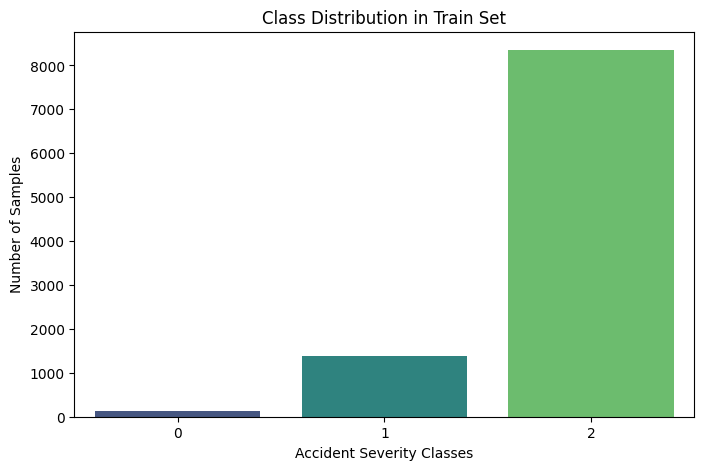

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_df["Accident_severity"], palette="viridis")
plt.xlabel("Accident Severity Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train Set")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: 2    8351
1    1380
0     121
Name: count, dtype: int64
After SMOTE: 2    8351
1    8351
0    8351
Name: count, dtype: int64


In [ ]:
print(pd.Series(y_train_resampled).value_counts())

2    8351
1    8351
0    8351
Name: count, dtype: int64


In [ ]:
class_counts = pd.Series(y_train_resampled).value_counts()
new_imbalance_ratio = class_counts.max() / class_counts.min()
print(f"New Imbalance Ratio: {new_imbalance_ratio:.2f}")

New Imbalance Ratio: 1.00


<ipython-input-33-03d6260832ea>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="viridis")


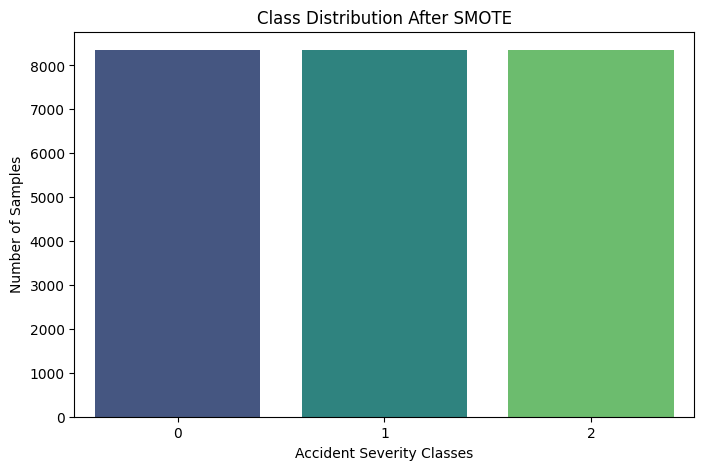

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_resampled, palette="viridis")
plt.xlabel("Accident Severity Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE")
plt.show()

# ANN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!pip install --upgrade pandas torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
print(train_features.shape[1])

27


In [ ]:
input_size = 27
hidden_size = 128
num_classes = 3
batch_size = 64
num_epochs = 100
learning_rate = 0.0005



In [ ]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


iter_count = 0
for epoch in range(num_epochs):
    for i in range(0, len(train_features), batch_size):
        inputs = train_features[i:i+batch_size].to(device)
        labels = train_labels[i:i+batch_size].to(device)


        # Check if labels are within the valid range
        if labels.min() < 0 or labels.max() >= num_classes:
            #print(f"Error: Invalid labels detected! Min: {labels.min()}, Max: {labels.max()}")

            # Adjust labels
            labels = torch.clamp(labels, 0, num_classes - 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter_count += 1
        if iter_count % 300 == 0:
            all_preds = []
            all_labels = []
            correct, total = 0, 0
            with torch.no_grad():
                for i in range(0, len(test_features), batch_size):
                    inputs = test_features[i:i+batch_size].to(device)
                    labels = test_labels[i:i+batch_size].to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()


            accuracy = accuracy_score(all_labels, all_preds) * 100
            precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"Iteration: {iter_count}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n" )

Iteration: 300. Loss: 0.5665. Accuracy: 83.16% . Precision: 0.7253. Recall: 0.8316. F1 Score:0.7640

Iteration: 600. Loss: 0.9329. Accuracy: 83.77% . Precision: 0.7017. Recall: 0.8377. F1 Score:0.7637

Iteration: 900. Loss: 0.5487. Accuracy: 83.77% . Precision: 0.7017. Recall: 0.8377. F1 Score:0.7637

Iteration: 1200. Loss: 0.6170. Accuracy: 83.77% . Precision: 0.7017. Recall: 0.8377. F1 Score:0.7637

Iteration: 1500. Loss: 0.3775. Accuracy: 83.77% . Precision: 0.7017. Recall: 0.8377. F1 Score:0.7637



# KNN

In [ ]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_labels = torch.tensor(y_test, dtype=torch.long)


In [ ]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Initialize KNN classifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)


batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 82.14% . Precision: 0.7334. Recall: 0.8214. F1 Score:0.7641



In [ ]:
# Initialize KNN classifier
k = 7
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)

batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.44% . Precision: 0.7578. Recall: 0.8344. F1 Score:0.7699



In [ ]:
# Initialize KNN classifier
k = 9
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)


batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.64% . Precision: 0.7618. Recall: 0.8364. F1 Score:0.7675



In [ ]:
# Initialize KNN classifier
k = 10
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)


batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.40% . Precision: 0.7447. Recall: 0.8340. F1 Score:0.7663



In [ ]:
# Initialize KNN classifier
k = 11
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)


batch_size = 64

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.77% . Precision: 0.7758. Recall: 0.8377. F1 Score:0.7652



In [ ]:
# Initialize KNN classifier
k = 13
knn = KNeighborsClassifier(n_neighbors=k)

# Train KNN
knn.fit(X_train, y_train)


batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = knn.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.73% . Precision: 0.7016. Recall: 0.8373. F1 Score:0.7635



# SVM

In [ ]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize SVM classifier
svm_model = SVC(kernel='linear', C=1.0)  #

# Train SVM
svm_model.fit(X_train, y_train)


batch_size = 64
iter_count = 0

for i in range(0, len(X_test), batch_size):
    iter_count += 1

    # Get batch
    batch_X = X_test[i:i + batch_size]
    batch_y = y_test[i:i + batch_size]

    # Predictions
    y_pred = svm_model.predict(batch_X)

    # Compute Metrics
    accuracy = accuracy_score(batch_y, y_pred) * 100
    precision = precision_score(batch_y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(batch_y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(batch_y, y_pred, average='weighted')


# Final evaluation on the full test set
y_pred_full = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_full) * 100
precision = precision_score(y_test, y_pred_full, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_full, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_full, average='weighted')

print("Final Evaluation:")
print(f"Accuracy: {accuracy:.2f}% . Precision: {precision:.4f}. Recall: {recall:.4f}. F1 Score:{f1:.4f}\n")


Final Evaluation:
Accuracy: 83.77% . Precision: 0.7017. Recall: 0.8377. F1 Score:0.7637

